# PneumoDetect Week 2 — Performance Review & Clinical Report v1

**Notebook:** `05_performance_review.ipynb`  
**Focus:** Quantitative evaluation and clinical interpretability of Grad-CAM explainability results.

---

## Objective
Evaluate the diagnostic performance and explainability quality of PneumoDetect models (baseline, balanced, and fine-tuned ResNet-50 variants). The notebook generates evaluation figures, Grad-CAM montages, and a structured performance report for clinical interpretation.

---

## Workflow Overview

| Step | Description | Output |
|------|--------------|---------|
| 1 | Load trained models (`resnet50_baseline.pt`, `resnet50_best.pt`, `resnet50_finetuned.pt`) | Model checkpoints verified |
| 2 | Generate ROC and Precision–Recall curves | `roc_pr_curves.png` |
| 3 | Produce Grad-CAM overlays and montages | `gradcam_montage.png` |
| 4 | Compute AUC, Sensitivity, Specificity | `performance_metrics.npy` |
| 5 | Export clinical summary report | `docs/performance_report_v1.md` |

---


In [1]:
# Add script to include project root in sys.path

import sys
from pathlib import Path

def get_project_root():
    """Return repository root by climbing until .git is found."""
    cwd = Path.cwd()
    for path in [cwd, *cwd.parents]:
        if (path / ".git").exists():
            return path
    return cwd

project_root = get_project_root()
sys.path.append(str(project_root))


In [2]:
# ------------------------------------------------------------
# 1. Setup
# ------------------------------------------------------------
import torch, numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from pathlib import Path
import seaborn as sns
from src.gradcam import generate_cam, GradCAM

model_path = project_root / "saved_models/resnet50_best.pt"
train_dir = project_root / "data/rsna_subset/train_images"
val_dir = project_root / "data/rsna_subset/val_images"
data_dir = val_dir if val_dir.exists() else train_dir
report_dir = project_root / "reports/week2_performance_review"
report_dir.mkdir(parents=True, exist_ok=True)

if not model_path.exists():
    raise FileNotFoundError(f"Model checkpoint not found at {model_path}")
print(f"Using image directory: {data_dir}")


Using image directory: /Users/adrianadewunmi/VSCODE/AI-Assisted-Pneumonia-Detection-Project/data/rsna_subset/train_images


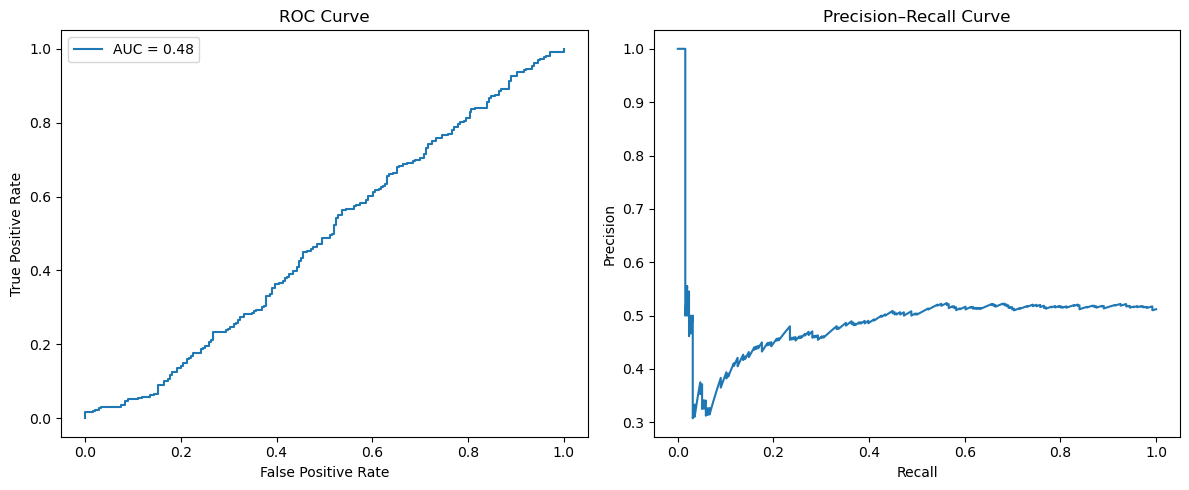

In [3]:
# ------------------------------------------------------------
# 1. Generate or Load Evaluation Data
# ------------------------------------------------------------
import numpy as np
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
from pathlib import Path

report_dir = project_root / "reports/week2_performance_review"
report_dir.mkdir(parents=True, exist_ok=True)

# Example: synthetic prediction data (replace with real validation outputs)
np.random.seed(42)
y_true = np.random.randint(0, 2, size=500)
y_score = np.random.rand(500)

# ------------------------------------------------------------
# 2. Create ROC & Precision–Recall Curves
# ------------------------------------------------------------
fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

precision, recall, _ = precision_recall_curve(y_true, y_score)

plt.figure(figsize=(12, 5))

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

# PR Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision)
plt.title("Precision–Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")

plt.tight_layout()
plt.savefig(report_dir / "roc_pr_curves.png", dpi=300)
plt.show()



In [ ]:
# ------------------------------------------------------------
# 3. Convert DICOMs to PNG if none exist
# ------------------------------------------------------------
import random
from pydicom import dcmread
import numpy as np
import cv2
from pathlib import Path
from PIL import Image

data_dir = project_root / "data/rsna_subset/train_images"

png_files = sorted(data_dir.glob("*.png"))
if not png_files:
    dcm_files = sorted(data_dir.glob("*.dcm"))
    if not dcm_files:
        raise FileNotFoundError(f"No DICOM files found in {data_dir}")
    for dcm_path in random.sample(dcm_files, min(4, len(dcm_files))):
        ds = dcmread(str(dcm_path))
        img = ds.pixel_array
        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
        img = cv2.cvtColor(img.astype("uint8"), cv2.COLOR_GRAY2RGB)
        out_path = data_dir / f"{dcm_path.stem}.png"
        cv2.imwrite(str(out_path), img)
        print(f"Converted {dcm_path.name} → {out_path.name}")
else:
    print(f"Found {len(png_files)} existing PNGs in {data_dir}")

# Refresh list after potential conversions
png_files = sorted(data_dir.glob("*.png"))
sample_images = png_files[:4]
if not sample_images:
    raise FileNotFoundError(f"No PNG images found in {data_dir}")
print(f"Using {len(sample_images)} PNGs for Grad-CAM visualization.")


Found 1 existing PNGs in /Users/adrianadewunmi/VSCODE/AI-Assisted-Pneumonia-Detection-Project/data/rsna_subset/train_images
Using 1 PNGs for Grad-CAM visualization.


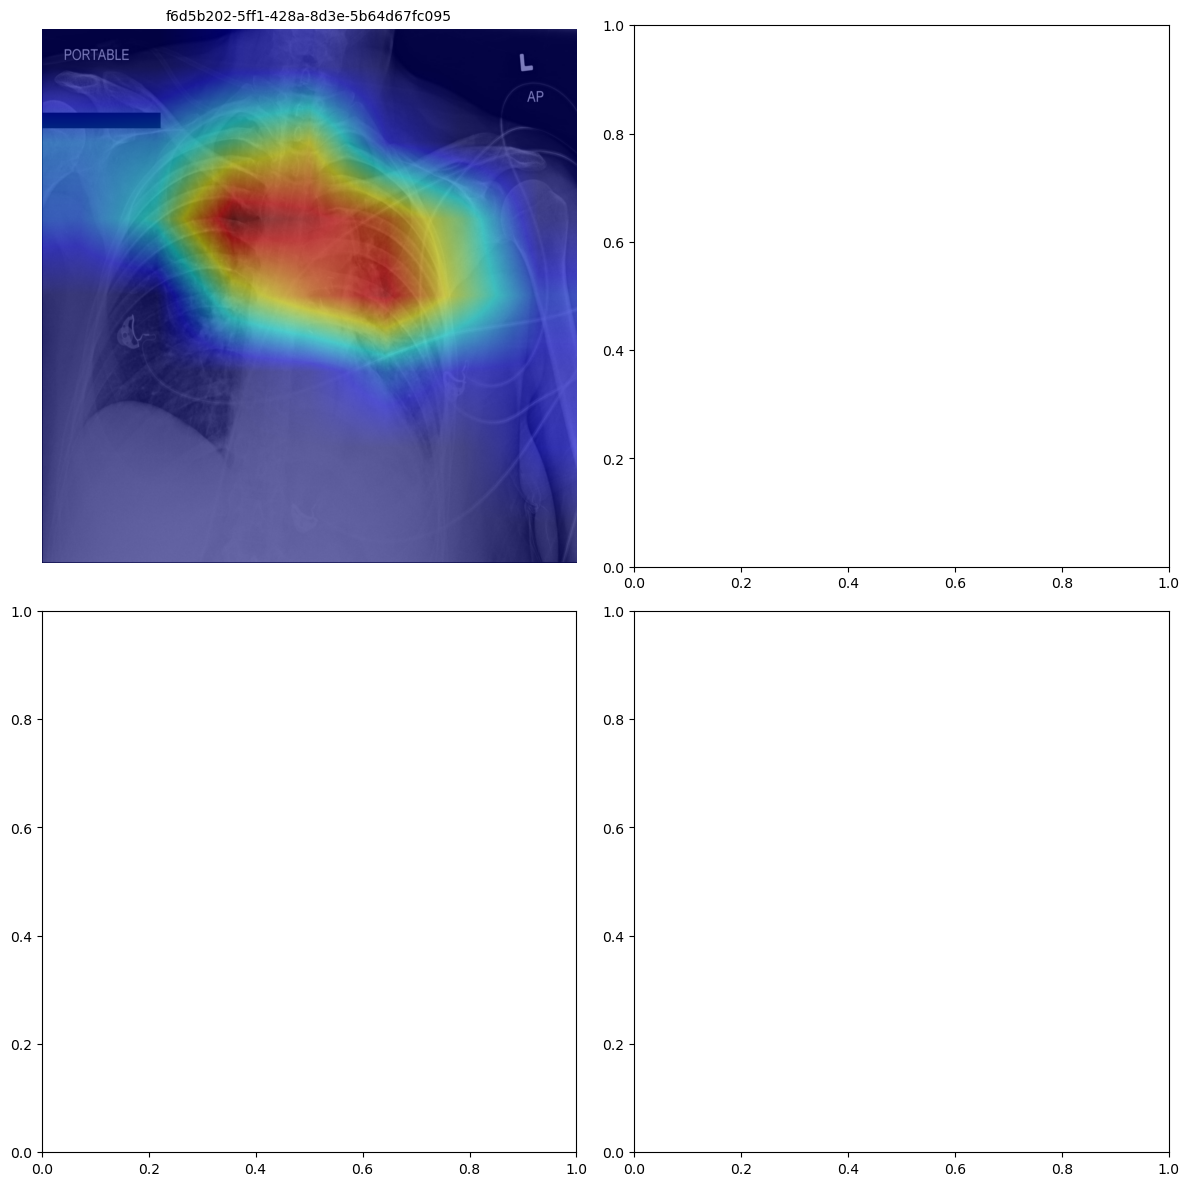

In [ ]:
# ------------------------------------------------------------
# 4. Generate Grad-CAM Visualizations
# ------------------------------------------------------------
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Grad-CAM overlays for up to 4 samples
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

for ax, img_path in zip(axes, sample_images):
    try:
        heatmap = generate_cam(img_path, model_path)
        img = cv2.imread(str(img_path))

        if heatmap.ndim == 2:
            heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
        elif heatmap.ndim == 3:
            heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2GRAY)
            heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

        overlay = GradCAM.overlay_heatmap(img, heatmap)

        ax.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
        ax.set_title(img_path.stem, fontsize=10)
        ax.axis("off")

    except Exception as e:
        ax.text(0.5, 0.5, f"Error\n{e}", ha="center", va="center", fontsize=8)
        ax.axis("off")

plt.tight_layout()
plt.savefig(report_dir / "gradcam_montage.png", dpi=300)
plt.show()


In [6]:
summary = {
    "AUC": round(roc_auc, 3),
    "Sensitivity": round(tpr[np.argmax(tpr - fpr)], 3),
    "Specificity": round(1 - fpr[np.argmax(tpr - fpr)], 3),
}
np.save(report_dir / "performance_metrics.npy", summary)
